In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pystan
import time
import scipy.stats as stats
import scipy

## Simulation parameters and data

In [16]:
def simulate(pars,seed):#simulation       

    import scipy.special as sc
    #Number of simulation trials
    N_sim = pars['N_sim'] 

    #NB-means
    r =pars['r']  

    #neurons numbers
    M = pars['M']

    #network weights
    b0= pars['b0']
    #b = np.random.uniform(-0.9,0.9,M) #random select from -1 to 1; 
    b = pars['b']
    #link function parameters
    loggam=pars['loggam']
    gam = np.exp(loggam)
  
    #sigma for beta prior
    s = pars['s']

    #trial bins
    K = pars['K'] #bins

    #input from other neuons
    x = np.ones(K)*3
    rng0 = np.random.default_rng(seed=2)
    for i in range(M-1):
        x_n = rng0.poisson(rng0.choice([6,8,7,5],p=[1/4]*4,size = 1),size = K)
        x = np.row_stack([x,x_n])


    # preset θ 
    mu = np.zeros(K)

    #preset y-true and y-simulatoin
    y_true = np.zeros(K)
    y_sim = np.zeros((K,N_sim))

    # true y value
    for i in range(K):
        mu[i] = (gam*np.exp(b0 + np.dot(x[:,i],b))+1)**(-1/gam)
        y_true[i] = r*(1/mu[i]-1) # true y value

    #simulate y value, via discrete sampling
    rng = np.random.default_rng(seed=seed)
    for i in range(K):
        for j in range(N_sim):
            phi = rng.beta(s*mu[i],s*(1-mu[i]))
            y_sim[i,j] = rng.negative_binomial(n = r, p = phi, size = 1)

    y_sim = y_sim.astype(int)

    print('simulation mse')
    print(np.sqrt(np.mean((y_sim-y_true.reshape(K,1))**2)))
    
    
    data = dict(x = x, y_sim = y_sim, y_true = y_true) 
    return data


# start simulation

pars = dict(
#Number of simulation trials
N_sim = 1,
#trial bins
K = 10,  #bins

#NB-means
r = 5,  
#neurons numbers
M = 20,
#network weights
b0= -0.5,
#b = np.random.uniform(-0.9,0.9,M) #random select from -1 to 1; 
b = [-0.1,-0.2,-0.3,-0.4,
     -0.1,-0.2,-0.3,-0.4,
     0.1,0.2,0.3,0.4,
     0.1,0.2,0.3,0.4,0.5,0.6,
    -0.2,-0.3],
#link function parameters
loggam=np.log(7),
#sigma for beta prior
s = 50,
)

data = simulate(pars,2)
x = data['x']
y_sim = data['y_sim']
y_true = data['y_true']

N_sim = pars['N_sim']
r = pars['r']
M = pars['M']
b0 = pars['b0']
b = pars['b']
loggam = pars['loggam']
s = pars['s']
K = pars['K']

simulation mse
8.033809620981208


## mcmc using stan

In [15]:
model = """
data {
  int<lower=1> N;    // rows of data, bins 
  int<lower=1> P;    // columns of data, trials
  int<lower=1> M;    // rows of neurons
  real x[M,N];       // M neurons, N bins
  int<lower=0> y[N,P]; // response
}
transformed data{
  real y_sum[N];
  for(i in 1:N){
    y_sum[i] = sum(y[i,]);
  }
}

parameters {
  real<lower=1,upper=7> r; // neg. binomial mean parameter
  real<lower=-1,upper=1>  b0;  // intercept
  real<lower=-1,upper=1>  b[M];  // slopes
  real<lower=30,upper=70> s;  //sigma
  real<lower=0,upper=3> loggam; //gamma
  real<lower=1e-9,upper=1-1e-9> phi[N];
  real<lower=1e-9,upper=1e9> l[N];
}


transformed parameters{
  real<lower=0,upper=1> mu[N]; 
  real<lower=0> alpha_0[N];
  real<lower=0> beta_0[N];
  real gam;
  gam = exp(loggam);
  for(i in 1:N){
    mu[i] = (gam*exp(b0 + dot_product(x[,i],b))+1)^(-1/gam);
    alpha_0[i] = s*mu[i];
    beta_0[i] = s*(1-mu[i]);
    }
}

model {   
  // data model:
  for(i in 1:N){
    phi[i] ~ beta(alpha_0[i], beta_0[i]);
    l[i] ~ gamma(r,phi[i]/(1-phi[i]));
    for(j in 1:P){
     y[i,j] ~ poisson(l[i]);
    }
  }
}

generated quantities {
  vector[N] y_new_sod_glm;
  for (n in 1:N){
    y_new_sod_glm[n] = r*(1/mu[n]-1);
  }
}
"""

sm = pystan.StanModel(model_code=model, verbose = 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c1f989d8f91d7ff11a5e3c5b833c6d61 NOW.
INFO:pystan:OS: linux, Python: 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0], Cython 0.29.16


Compiling /tmp/pystan_q9emodid/stanfit4anon_model_c1f989d8f91d7ff11a5e3c5b833c6d61_4695395412552376605.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_q9emodid/stanfit4anon_model_c1f989d8f91d7ff11a5e3c5b833c6d61_4695395412552376605.pyx
building 'stanfit4anon_model_c1f989d8f91d7ff11a5e3c5b833c6d61_4695395412552376605' extension
creating /tmp/pystan_q9emodid/tmp
creating /tmp/pystan_q9emodid/tmp/pystan_q9emodid
/home/msc/app/anaconda3/envs/mcmcstan/bin/x86_64-conda_cos6-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/msc/app/anaconda3/envs/mcmcstan/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/msc/app/anaconda3/envs/mcmcstan/include -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_q9emodid -I/home/msc/app/anaconda3/envs/mcmcstan/lib/python3.6/site-packages/pystan -I/home/msc/app/anaconda3/en

### Optimization models


In [17]:
#objective function, calculate the maximum likelihood for SOD model
def S0D_sum(x0, K, y, x):
  r=x0[0]
  b0=x0[1]
  loggam=x0[2]
  s=x0[3]
  b=x0[4:]
  import scipy.special as sc
  LL_sum = np.zeros(y_sim.shape)
  for i in range(y_sim.shape[0]):
    gam = np.exp(loggam)
    mu = (gam*np.exp(b0+np.dot(x[:,i],b))+1)**(-1/gam)
    for j in range(y_sim.shape[1]):
      LL_sum[i,j]=sc.gammaln(r+s*mu)+sc.gammaln(y_sim[i,j]+s-s*mu)+ \
          sc.gammaln(r+y_sim[i,j])+sc.gammaln(s)-\
          sc.gammaln(r+y_sim[i,j]+s)-sc.gammaln(r)-\
          sc.gammaln(s*mu)-sc.gammaln(s-s*mu)-sc.gammaln(y_sim[i,j]+1)


  LL_sum = -1*np.sum(LL_sum)
  return LL_sum


#objective function, calculate the maximum likelihood for NBGLM model
def NBGLM_sum(x0, K, y, x):
  r=x0[0]
  b0=x0[1]
  loggam=x0[2]
  b=x0[3:]
  gam = np.exp(loggam)

  import scipy.special as sc
  LL_sum = np.zeros(y_sim.shape)

  for i in range(y_sim.shape[0]):
    mu = (gam*np.exp(b0+np.dot(x[:,i],b))+1)**(-1/gam)
    for j in range(y_sim.shape[1]):
      LL_sum[i,j]=sc.gammaln(r+y_sim[i,j])-\
                  sc.gammaln(y_sim[i,j]+1)- \
                  sc.gammaln(r)+\
                  r*np.log(mu)+\
                  y_sim[i,j]*np.log(1-mu)

  LL_sum = -1*np.sum(LL_sum)
  return LL_sum

### rmse

In [18]:
# prediction rmse
def rmse_nbglm(op,x,y_sim,y_true):
  #get parameters
  x_op = op.x
  r_op=x_op[0]
  b0_op=x_op[1]
  loggam_op=x_op[2]
  b_op=x_op[3:]
  gam_op = np.exp(loggam_op)

  K = x.shape[1]
  response = np.zeros((K,))

  for i in range(K):
      mu = (gam_op*np.exp(b0_op+np.dot(x[:,i],b_op))+1)**(-1/gam_op)
      response[i] = (r_op*(1/mu-1));

  rmse_true = np.sqrt(np.mean((y_true-response)**2))
  rmse_sim = np.sqrt(np.mean((y_sim-response.reshape(K,1))**2))

  return rmse_true, rmse_sim, response

def rmse_sod(op,x,y_sim,y_true):
  #get parameters
  x_op = op.x
  r_op=x_op[0]
  b0_op=x_op[1]
  loggam_op=x_op[2]
  s_op = x_op[3]
  b_op=x_op[4:]
  gam_op = np.exp(loggam_op)

  K = x.shape[1]
  response = np.zeros((K,))
  N_sim = y_sim.shape[1]

  for i in range(K):
      mu = (gam_op*np.exp(b0_op+np.dot(x[:,i],b_op))+1)**(-1/gam_op)
      #theta_eb = (N_sim*r_op+s_op*mu)/(N_sim*r_op+np.sum(y_sim,1)[i]+s_op);
      response[i] = (r_op*(1/mu-1))

  rmse_true = np.sqrt(np.mean((y_true-response)**2))
  rmse_sim = np.sqrt(np.mean((y_sim-response.reshape(K,1))**2))

  return rmse_true, rmse_sim, response
    
def rmse_mcmc(fit,x,y_sim,y_true):
  K = x.shape[1]
  mcmc_pred_y = np.mean(fit['y_new_sod_glm'], axis = 0)
  rmse_true = np.sqrt(np.mean((y_true - mcmc_pred_y)**2))
  rmse_sim = np.sqrt(np.mean((y_sim - mcmc_pred_y.reshape(K,1))**2))
  return rmse_true, rmse_sim, mcmc_pred_y

# Modeling (N_iter)

In [19]:
#start modeling
history = dict()
N_iter = 20

#bounds sod
bnds_sod = [[1,7],[0,10],[0,3],[30,70]]
bnds_sod.extend([[-1,1]]*M)

#bounds nbglm
bnds_nbglm = [[1,7],[0,10],[0,3]]
bnds_nbglm.extend([[-1,1]]*M)

seeds = range(N_iter)
for sim_i in range(N_iter):
  #get simulation data
  data = simulate(pars, seeds[sim_i])
  x = data['x']
  y_sim = data['y_sim']
  y_true = data['y_true']

  N_sim = pars['N_sim']
  r = pars['r']
  M = pars['M']
  b0 = pars['b0']
  b = pars['b']
  loggam = pars['loggam']
  s = pars['s']
  K = pars['K']


   #simulation N_iter times
  #SOD model
  x0 = [r,b0,loggam,s]
  x0.extend(b)
  t0 = time.time()
  op_sod = scipy.optimize.minimize(S0D_sum, x0, args=(K, y_sim, x,), \
                                 bounds = bnds_sod, method='SLSQP')
  t1 = time.time()
  t_sod = t1-t0
  if not op_sod.success:
    print('not converge in sod model')

  #rmse
  rmse_sod_true, rmse_sod_sim, y_sod_est = rmse_sod(op_sod,x,y_sim,y_true) 
  #record
  history['op_sod_'+str(sim_i)] = op_sod
  history['t_sod_'+str(sim_i)] = t_sod
  history['rmse_sod_true'+str(sim_i)] = rmse_sod_true
  history['rmse_sod_sim'+str(sim_i)] = rmse_sod_sim
  history['y_sod_est'+str(sim_i)] = y_sod_est

  
  #NBGLM model
  x1 = [r,b0,loggam]
  x1.extend(b)
  t0 = time.time()
  op_nbglm = scipy.optimize.minimize(NBGLM_sum, x1, bounds = bnds_nbglm,
                              args=(K, y_sim, x,), \
                            method='SLSQP')
  t1 = time.time()
  t_nb = t1-t0
  if not op_nbglm.success:
    print('not converge in nbglm model')

  #rmse
  rmse_nbglm_true, rmse_nbglm_sim, y_nbglm_est = rmse_nbglm(op_nbglm,x,y_sim,y_true)
  #record
  history['op_nbglm_'+str(sim_i)] = op_nbglm
  history['t_nbglm_'+str(sim_i)] = t_nb
  history['rmse_nbglm_true'+str(sim_i)] = rmse_nbglm_true
  history['rmse_nbglm_sim'+str(sim_i)] = rmse_nbglm_sim
  history['y_nbglm_est'+str(sim_i)]=y_nbglm_est


  #MCMC model
  t0 = time.time()
  fit = sm.sampling(data = dict(N = K, M = M, P = N_sim, y = y_sim, x=x),
                  #pars = ["b0", "b1", 'b2', "r",'s','gam'],
                  init= 'random',
                  seed = 4,
                  iter = 1000, 
                  n_jobs = 4,
                  chains = 4,
                  #control = dict(adapt_delta=1,max_treedepth=12),
                  verbose = True)
  t1 = time.time()
  t_mcmc = t1-t0

  #rmse
  rmse_mcmc_true, rmse_mcmc_sim, y_mcmc_est = rmse_mcmc(fit,x,y_sim,y_true)
  #record
  history['mcmc_fit'+str(sim_i)] = fit
  history['mcmc_t'+str(sim_i)] = t_mcmc
  history['rmse_mcmc_true'+str(sim_i)] = rmse_mcmc_true
  history['rmse_mcmc_sim'+str(sim_i)] = rmse_mcmc_sim
  history['y_mcmc_est'+str(sim_i)] = y_mcmc_est
#

simulation mse
33.080079493447556


/home/msc/app/anaconda3/envs/mcmcstan/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
/home/msc/app/anaconda3/envs/mcmcstan/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


simulation mse
4.304102442641915


/home/msc/app/anaconda3/envs/mcmcstan/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


simulation mse
8.033809620981208
simulation mse
3.2027043712746393


simulation mse
39.09787287555817


simulation mse
7.758139548397591


simulation mse
7.080123157176505


simulation mse
2.4047267706815862
simulation mse
11.992661945853632


simulation mse
6.7829497504797


simulation mse
3.632810004655066
simulation mse
6.615081218354977


simulation mse
6.9897808490222175


simulation mse
4.875371115641926


simulation mse
5.1170537104227


simulation mse
15.606542336784921
simulation mse
7.646907967650386


simulation mse
7.335841513972694
simulation mse
4.729285288519964


simulation mse
5.952252523670086


## Visualization of weights

In [20]:
def plot_b(b_pred, b_true, name):
  b_mean = np.mean(b_pred, axis = 0)
  b_error = stats.sem(b_pred,axis =0)

  import matplotlib.pyplot as plt
  from matplotlib.patches import Circle

  fig, ax = plt.subplots(figsize=(3, 3))

  #line
  x_plot = np.linspace(-1,1,100)
  y_plot = x_plot
  plt.plot(x_plot, y_plot, '-b', label='y=x')

  #points
  for i in range(len(b_true)):
      p = Circle((b_true[i], b_mean[i]), np.sqrt(b_error[i]/np.pi), alpha = 0.4)
      ax.add_artist(p)
  # plt.scatter(b,b_pred_op_mean,s=np.sqrt(np.abs(b_pred_op_error)))

  plt.ylim([-1.2,1.2])
  plt.xlim([-1.2,1.2])
  plt.xlabel('True weights')
  plt.ylabel('Estimated weights')
  plt.title(name)
  plt.plot()



## rmse

In [25]:
def get_rmse(rmse, order):
  #order: true,0; sim: 1
  import scipy.stats
  rmse_mean = np.mean(rmse, axis = 0)
  rmse_error = stats.sem(rmse,axis =0)/np.abs(rmse_mean)

  return rmse_mean[order],rmse_error[order]

In [27]:
from scipy import stats
# true, sim
rmse_mcmc_arr = np.zeros((N_iter,2))
rmse_sod_arr = np.zeros((N_iter,2))
rmse_nbglm_arr = np.zeros((N_iter,2))
for i in range(N_iter):
  #mcmc
  rmse_mcmc_arr[i,0] = history['rmse_mcmc_true'+str(i)]
  rmse_mcmc_arr[i,1] = history['rmse_mcmc_sim'+str(i)]
  

  #sod
  rmse_sod_arr[i,0] = history['rmse_sod_true'+str(i)]
  rmse_sod_arr[i,1] = history['rmse_sod_sim'+str(i)]
  

  #nbglm
  rmse_nbglm_arr[i,0] = history['rmse_nbglm_true'+str(i)]
  rmse_nbglm_arr[i,1] = history['rmse_nbglm_sim'+str(i)]
  

rmse_mcmc_mean,rmse_mcmc_error = get_rmse(rmse_mcmc_arr, 0)
rmse_sod_mean,rmse_sod_error = get_rmse(rmse_sod_arr, 0)
rmse_nbglm_mean,rmse_nbglm_error = get_rmse(rmse_nbglm_arr, 0)

print(rmse_mcmc_mean,rmse_sod_mean,rmse_nbglm_mean)
print(rmse_mcmc_error,rmse_sod_error,rmse_nbglm_error)

5.484562740751698 8.802798001728219 9.611235728916029
0.09052545771743097 0.20177407883340784 0.22284345074107567


### time for processing

In [32]:
from scipy import stats
# true, sim
t_mcmc = np.zeros((N_iter,1))
t_sod = np.zeros((N_iter,1))
t_nbglm = np.zeros((N_iter,1))
for i in range(N_iter):
  # mcmc
  t_mcmc[i,0] = history['mcmc_t'+str(sim_i)]

  #sod
  t_sod[i,0] = history['t_sod_'+str(i)]

  #nbglm
  t_nbglm[i,0] = history['t_nbglm_'+str(i)]
    
t_mcmc_mean = np.mean(t_mcmc)
t_sod_mean = np.mean(t_sod)
t_nbglm_mean = np.mean(t_nbglm) 

print(t_mcmc_mean, t_sod_mean,t_nbglm_mean)

6.004557847976685 0.3622146129608154 0.19660453796386718


## estimated spike counts with real spike couts


In [33]:
#recalculate y true and y sim
for i in range(N_iter):
  #get simulation data
  data = simulate(pars, seeds[i])
  x = data['x']
  y_sim = data['y_sim']
  y_true = data['y_true']

  #mcmc
  fit = history['mcmc_fit'+str(i)]
  #sod
  op_sod = history['op_sod_'+str(i)]

  #nbglm
  op_nbglm = history['op_nbglm_'+str(i)]

  if i == 0:
    y_response = y_true
    mcmc_response = rmse_mcmc(fit,x,y_sim,y_true)[2]
    sod_response = rmse_sod(op_sod,x,y_sim,y_true)[2]
    nbglm_response = rmse_nbglm(op_nbglm,x,y_sim,y_true)[2]
  else:
    y_response = np.append(y_response, y_true)
    mcmc_response = np.append(mcmc_response, rmse_mcmc(fit,x,y_sim,y_true)[2])
    sod_response = np.append(sod_response, rmse_sod(op_sod,x,y_sim,y_true)[2])
    nbglm_response = np.append(nbglm_response, rmse_nbglm(op_nbglm,x,y_sim,y_true)[2])
        

simulation mse
33.080079493447556
simulation mse
4.304102442641915
simulation mse
8.033809620981208
simulation mse
3.2027043712746393
simulation mse
39.09787287555817
simulation mse
7.758139548397591
simulation mse
7.080123157176505
simulation mse
2.4047267706815862
simulation mse
11.992661945853632
simulation mse
6.7829497504797
simulation mse
3.632810004655066
simulation mse
6.615081218354977
simulation mse
6.9897808490222175
simulation mse
4.875371115641926
simulation mse
5.1170537104227
simulation mse
15.606542336784921
simulation mse
7.646907967650386
simulation mse
7.335841513972694
simulation mse
4.729285288519964
simulation mse
5.952252523670086


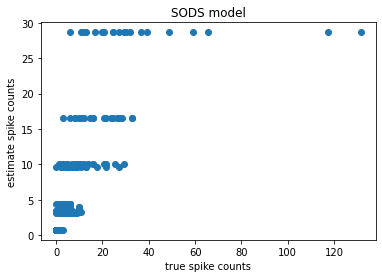

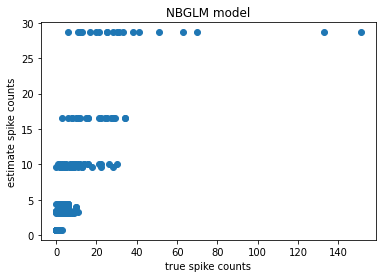

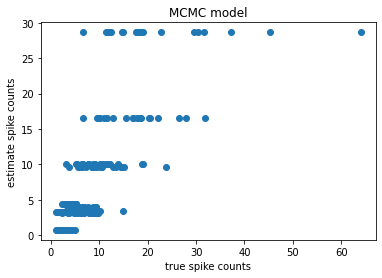

In [36]:
plt.plot(sod_response, y_response, 'o')
plt.xlabel('true spike counts')
plt.ylabel('estimate spike counts')
plt.title('SODS model')
plt.show()

plt.plot(nbglm_response, y_response, 'o')
plt.xlabel('true spike counts')
plt.ylabel('estimate spike counts')
plt.title('NBGLM model')
plt.show()


plt.plot(mcmc_response, y_response, 'o')
plt.xlabel('true spike counts')
plt.ylabel('estimate spike counts')
plt.title('MCMC model')
plt.show()

## SAVE RECORD

In [39]:
import pickle
import random
file_id = 'K'+str(K)+'_Sim'+str(N_sim)+\
'_gam_'+str(np.int(np.round(np.exp(loggam))))+\
'_s'+str(s)+'_r'+str(r)+'_Ne'+str(M)+'.pkl'

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open(file_id, 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump({'model':sm, 
                 'history':history,
                 'pars':pars,
                 'rmse':[rmse_mcmc_mean,rmse_mcmc_error,
                         rmse_sod_mean,rmse_sod_error,
                         rmse_nbglm_mean,rmse_nbglm_error],
                 't':[t_mcmc_mean,t_sod_mean,t_nbglm_mean],
                'p':[p_mcmc, p_sod, p_nbglm]},
                f, protocol=-1)


/home/msc/app/anaconda3/envs/mcmcstan/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
